# ResNet Preprocessing

Copy this notebook and set the paths to start preprocessing your data.

Note: If you are going to update this notebooks, clear the outputs before committing.

## Loading the Data

The code below loads data and labels from GCS.

You should update the paths to save the data to the right place on
your local disk.

### Arrays

In [ ]:
# Keeps the data in the local filesystem in-sync with GCS
!gsutil -m rsync -d -r gs://elvos/numpy /home/elvo-analysis/data/numpy/

Building synchronization state...
Starting synchronization
Copying gs://elvos/numpy/04IOS24JP70LHBGB.npy...
Copying gs://elvos/numpy/02SNCL4L74HH1N2V.npy...
Copying gs://elvos/numpy/0MG5EK1O64CPS887.npy...
Copying gs://elvos/numpy/0KSBX96F8BU1FCFQ.npy...
Copying gs://elvos/numpy/0MTDDGCF20DKOR59.npy...
Copying gs://elvos/numpy/ABPO2BORDNF3OVL3.npy...
Copying gs://elvos/numpy/0DQO9A6UXUQHR8RA.npy...
Copying gs://elvos/numpy/0E1AN2T001WORM02.npy...
Copying gs://elvos/numpy/AGTRMFUZM2MQUAB4.npy...
Copying gs://elvos/numpy/ADJYK6PUQSLE2GLN.npy...
Copying gs://elvos/numpy/0EZJW4R4EMC16I10.npy...
Copying gs://elvos/numpy/AFEB6XW5UCQTSYJL.npy...
Copying gs://elvos/numpy/AHNGBFJSTEBO4BJW.npy...
Copying gs://elvos/numpy/ADKFJYDHLE7M3XE6.npy...
Copying gs://elvos/numpy/0LT6HMDHUK63WSC7.npy...
Copying gs://elvos/numpy/AGTDPQEU54ODFAUD.npy...
Copying gs://elvos/numpy/ANLMZN6NS4S3TCCF.npy...
Copying gs://elvos/numpy/AFN5EQGSDERZCTLM.npy...
Copying gs://elvos/numpy/ANCCICBPHIDJ5PJ4.npy...
Copying gs

Copying gs://elvos/numpy/OQNPNGEBR4D54PRA.npy...e  82.8 MiB/s ETA 00:14:17      
Copying gs://elvos/numpy/OQWBV4PPVHOOYRWI.npy...e 107.8 MiB/s ETA 00:10:58      
Copying gs://elvos/numpy/ORIKPYK3H2CCVFBR.npy...e  96.9 MiB/s ETA 00:12:11      
Copying gs://elvos/numpy/OSO6K4FGNA57I3VJ.npy...e  96.9 MiB/s ETA 00:12:11      
Copying gs://elvos/numpy/OTIGVYUMMBXDNSHN.npy...e  77.7 MiB/s ETA 00:15:11      
Copying gs://elvos/numpy/OTIP25YORHBKJPZM.npy...e  46.8 MiB/s ETA 00:25:12      
Copying gs://elvos/numpy/OUM3NFGU5U3TCBBK.npy...e  52.4 MiB/s ETA 00:22:30      
Copying gs://elvos/numpy/OXLMK9HYYWBECM3T.npy...e  56.2 MiB/s ETA 00:20:57      
Copying gs://elvos/numpy/OXRK4I6CTXCENAZV.npy...e  55.7 MiB/s ETA 00:21:10      
Copying gs://elvos/numpy/P4AIB8JMDY6RDRAP.npy...e  66.0 MiB/s ETA 00:17:50      
Copying gs://elvos/numpy/P64MELY8IJSLJ1WW.npy...e  68.0 MiB/s ETA 00:17:17      
Copying gs://elvos/numpy/P8D6HTN341UCLBIT.npy...e  99.4 MiB/s ETA 00:11:49      
Copying gs://elvos/numpy/PAH

In [1]:
import os
import pathlib
import typing

import numpy as np

In [2]:
def load_data(data_dir: str) -> typing.Dict[str, np.ndarray]:
    """Returns a dictionary which maps patient ids
    to patient pixel data."""
    data_dict = {}
    for filename in os.listdir(data_dir):
        patient_id = filename[:-4] # remove .npy extension
        data_dict[patient_id] = np.load(pathlib.Path(data_dir) / filename)
    return data_dict

In [3]:
data_dict = load_data('/home/elvo-analysis/data/numpy/')

### Labels

In [5]:
!gsutil cp gs://elvos/labels.csv /home/elvo-analysis/data/labels.csv

Copying gs://elvos/labels.csv...
/ [1 files][ 20.0 KiB/ 20.0 KiB]                                                
Operation completed over 1 objects/20.0 KiB.                                     


In [4]:
import pandas as pd

In [5]:
labels_df = pd.read_csv('/home/elvo-analysis/data/labels.csv',
                        index_col='patient_id')

## Preprocessing: Part I

If we use gs://elvos/numpy or gs://elvos/labels.csv, we'll have to do some minor
preprocessing first (removing bad data and duplicate labels).

In [6]:
def process_images(data: typing.Dict[str, np.ndarray]):
    return {id_: arr for id_, arr in data.items() if len(arr) != 1} # Remove the bad image

In [7]:
data_dict = process_images(data_dict)

In [8]:
def process_labels(labels: pd.DataFrame, data: typing.Dict[str, np.ndarray]):
    # TODO: Remove duplicate HLXOSVDF27JWNCMJ, IYDXJTFVWJEX36DO from ELVO_key
    labels = labels.loc[~labels.index.duplicated()] # Remove duplicate ids
    labels = labels.loc[list(data.keys())]
    assert len(labels) == len(data)
    return labels

In [9]:
labels_df = process_labels(labels_df, data_dict)

## Data Exploration

Simple plotting of the (mostly) unprocessed data.

For the data in `numpy/`:
- The 6 smallest image heights are: 1, 160, 160, 162, 164, 181.
- The 5 smallest image lengths/widths are: 180, 191, 193, 195, 197.

In [10]:
%matplotlib inline

In [11]:
from matplotlib import pyplot as plt

In [12]:
def plot_images(data: typing.Dict[str, np.ndarray],
                labels: pd.DataFrame,
                num_cols: int,
                limit=20,
                offset=0):
    # Ceiling function of len(data) / num_cols
    num_rows = (min(len(data), limit) + num_cols - 1) // num_cols 
    fig = plt.figure(figsize=(10, 10))
    for i, patient_id in enumerate(data):
        if i < offset:
            continue
        if i >= offset + limit:
            break
        plot_num = i - offset + 1
        ax = fig.add_subplot(num_rows, num_cols, plot_num)
        ax.set_title(f'patient: {patient_id[:4]}...')
        label = 'positive' if labels.loc[patient_id]["label"] else 'negative'
        ax.set_xlabel(f'label: {label}')
        plt.imshow(data[patient_id])
    fig.tight_layout()
    plt.plot()

In [13]:
# Change the input to .transpose to see different views of the data
mipped_all = {k:data_dict[k].transpose(0, 2, 1).max(axis=2) for i, k in enumerate(data_dict)}

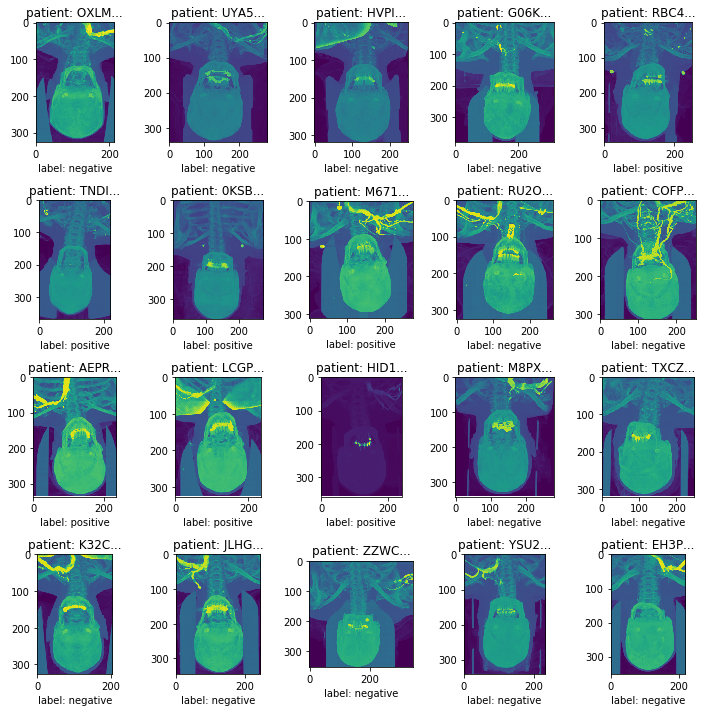

In [14]:
plot_images({k: arr for k, arr in mipped_all.items()}, labels_df, 5, offset=20)

## Preprocessing: Part II

Cropping the image, applying mip, etc.

You should

In [15]:
import scipy.ndimage

In [178]:
def crop(image3d: np.ndarray,
         output_shape) -> np.ndarray:
    """Crops a 3d image in ijk form (height as axis 0).
    """
    assert image3d.shape[1] == image3d.shape[2]
    assert output_shape[1] == output_shape[2] # For now
    assert output_shape[1] <= image3d.shape[1]
    
    lw_center = image3d.shape[1] // 2
    lw_min = lw_center - output_shape[1] // 2
    lw_max = lw_center + output_shape[1] // 2
    for i in range(len(image3d) - 1, 0, -1):
        if image3d[i, lw_center, lw_center] >= 0:
            height_max = i - 30
            break
    height_min = height_max - output_shape[0]
    
    cropped = image3d[height_min:height_max, lw_min:lw_max, lw_min:lw_max]
    assert cropped.shape == output_shape
    return cropped


def bound_pixels(image3d: np.ndarray,
                 min_bound: float,
                 max_bound: float) -> np.ndarray:
    return np.clip(image3d, min_bound, max_bound)


def mip(image3d: np.ndarray) -> np.ndarray:
    """Make sure that the array has been transposed first!
    """
#     assert image3d.shape[0] == image3d.shape[1]
    return image3d.max(axis=2)


def downsample(image3d: np.ndarray, factor) -> np.ndarray:
    return scipy.ndimage.zoom(image3d, factor)
    

def to_grayscale(image2d: np.ndarray):
    return np.stack([image2d, image2d, image2d], axis=2)


def process_data(data: typing.Dict[str, np.ndarray]) -> typing.Dict[str, np.ndarray]:
    processed = {}
    for id_, arr in data.items():
        try:
#             arr = crop(arr, (75, 200, 200))
#             arr = np.stack([arr[0:25], arr[25:50], arr[50:75]])
#             arr = arr.max(axis=1)
            arr = arr.transpose(0, 2, 1)
            arr = np.rot90(arr, 2)
            
            x = arr.shape[0] // 2
            y = arr.shape[1] // 2
            
            for i in range(len(arr)):
                if arr[x, y, i] >= 0:
                    height_min = i
                    break
            
            offset = 60
            arr = np.array([arr[:-50,:,height_min+offset:height_min+offset+20],
                            arr[:-50,:,height_min+offset+20:height_min+offset+40],
                            arr[:-50,:,height_min+offset+40:height_min+offset+60]])
            arr = np.moveaxis(arr, 0, -1)
            tmp = bound_pixels(arr, -40, 400)
            tmp[tmp == 400] = 0
#                 tmp = bound_pixels(tmp, -40, 100)
            arr = mip(tmp)
            print(np.shape(arr))
#             assert arr.shape == (200, 200, 3)
            processed[id_] = arr
        except AssertionError:
            print(f'image for patient {id_} too small, has shape {arr.shape}')
    return processed

In [179]:
processed_dict = process_data(data_dict)

(290, 250, 3)
(299, 357, 3)
(301, 281, 3)
(278, 250, 3)
(276, 280, 3)
(285, 280, 3)
(259, 282, 3)
(296, 305, 3)
(271, 280, 3)
(369, 248, 3)
(286, 259, 3)
(288, 250, 3)
(275, 250, 3)
(297, 235, 3)
(329, 200, 3)
(291, 280, 3)
(265, 289, 3)
(297, 217, 3)
(275, 219, 3)
(324, 263, 3)
(276, 213, 3)
(291, 280, 3)
(269, 250, 3)
(329, 313, 3)
(291, 250, 3)
(319, 220, 3)
(312, 275, 3)
(261, 275, 3)
(275, 262, 3)
(263, 251, 3)
(287, 235, 3)
(277, 235, 3)
(308, 242, 3)
(291, 280, 3)
(271, 248, 3)
(276, 205, 3)
(295, 245, 3)
(305, 344, 3)
(291, 233, 3)
(301, 219, 3)
(318, 250, 3)
(305, 235, 3)
(261, 235, 3)
(321, 272, 3)
(254, 218, 3)
(290, 250, 3)
(159, 250, 3)
(306, 260, 3)
(267, 250, 3)
(250, 284, 3)
(304, 231, 3)
(291, 280, 3)
(325, 251, 3)
(341, 235, 3)
(282, 269, 3)
(306, 250, 3)
(291, 280, 3)
(312, 290, 3)
(265, 269, 3)
(325, 266, 3)
(308, 250, 3)
(290, 244, 3)
(319, 273, 3)
(291, 250, 3)
(281, 245, 3)
(347, 255, 3)
(291, 280, 3)
(335, 272, 3)
(277, 306, 3)
(264, 250, 3)
(291, 280, 3)
(311, 

(303, 235, 3)
(255, 239, 3)
(273, 263, 3)
(288, 250, 3)
(277, 283, 3)
(299, 250, 3)
(303, 279, 3)
(275, 250, 3)
(291, 280, 3)
(319, 251, 3)
(286, 250, 3)
(114, 250, 3)
(286, 280, 3)
(267, 235, 3)
(235, 282, 3)
(293, 250, 3)
(289, 250, 3)
(252, 279, 3)
(291, 259, 3)
(318, 250, 3)
(291, 280, 3)
(301, 281, 3)
(293, 255, 3)
(271, 227, 3)
(278, 280, 3)
(232, 250, 3)
(292, 225, 3)
(248, 210, 3)
(278, 448, 3)
(331, 295, 3)
(278, 280, 3)
(291, 280, 3)
(246, 235, 3)
(317, 246, 3)
(249, 280, 3)
(291, 280, 3)
(332, 250, 3)
(268, 250, 3)
(240, 248, 3)
(291, 250, 3)
(248, 250, 3)
(285, 289, 3)
(240, 252, 3)
(500, 303, 3)
(261, 250, 3)
(335, 260, 3)
(320, 305, 3)
(298, 255, 3)
(291, 280, 3)
(303, 229, 3)
(271, 235, 3)
(302, 273, 3)
(265, 217, 3)
(317, 246, 3)
(262, 265, 3)
(322, 250, 3)
(245, 280, 3)
(297, 304, 3)
(284, 250, 3)
(302, 250, 3)
(286, 267, 3)
(307, 254, 3)
(250, 250, 3)
(295, 249, 3)
(295, 248, 3)
(281, 280, 3)
(305, 223, 3)
(229, 248, 3)
(276, 280, 3)
(282, 267, 3)
(259, 226, 3)
(250, 

In [180]:
processed_df = labels_df.loc[processed_dict.keys()]

## Data Validation

Check to see that the data looks right.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

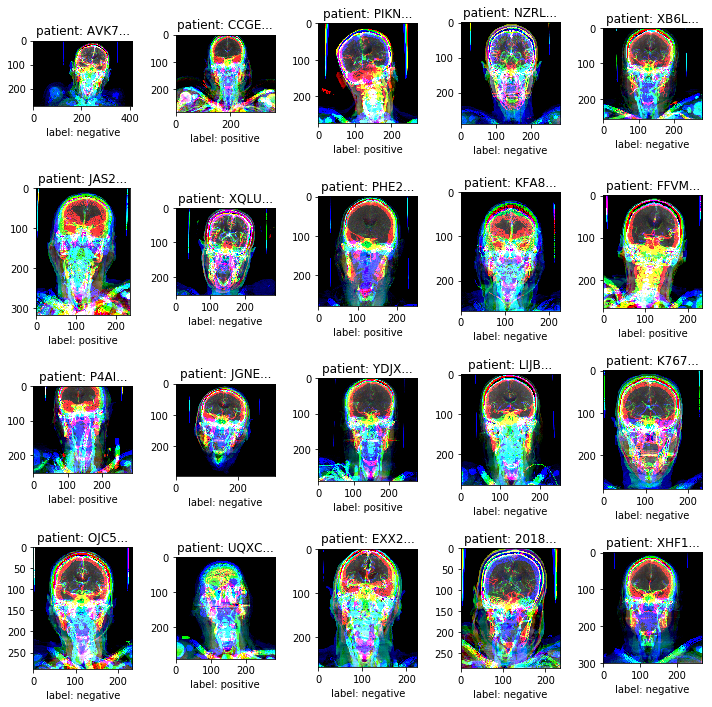

In [181]:
plot_images({k: arr for k, arr in processed_dict.items()}, labels_df, 5, offset=120)

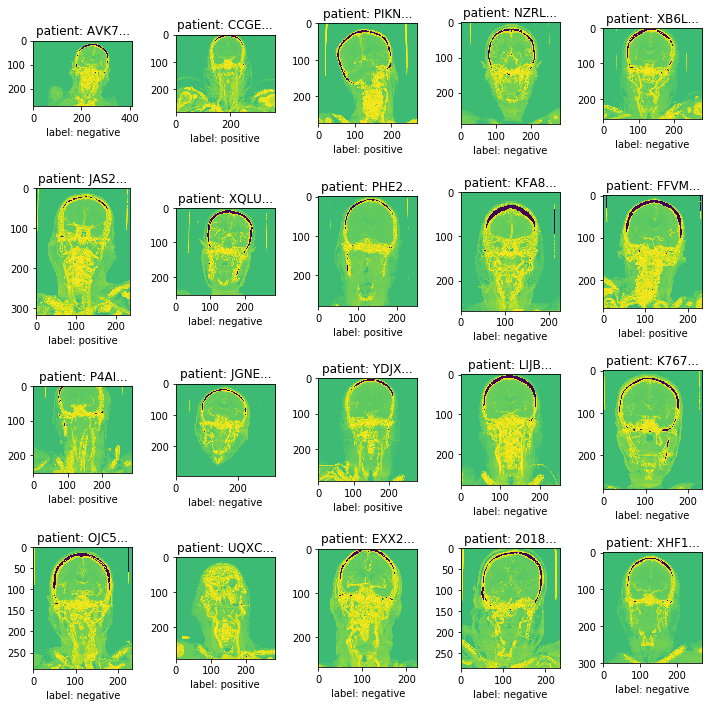

In [170]:
plot_images({k: arr[:,:,1] for k, arr in processed_dict.items()}, labels_df, 5, offset=120)

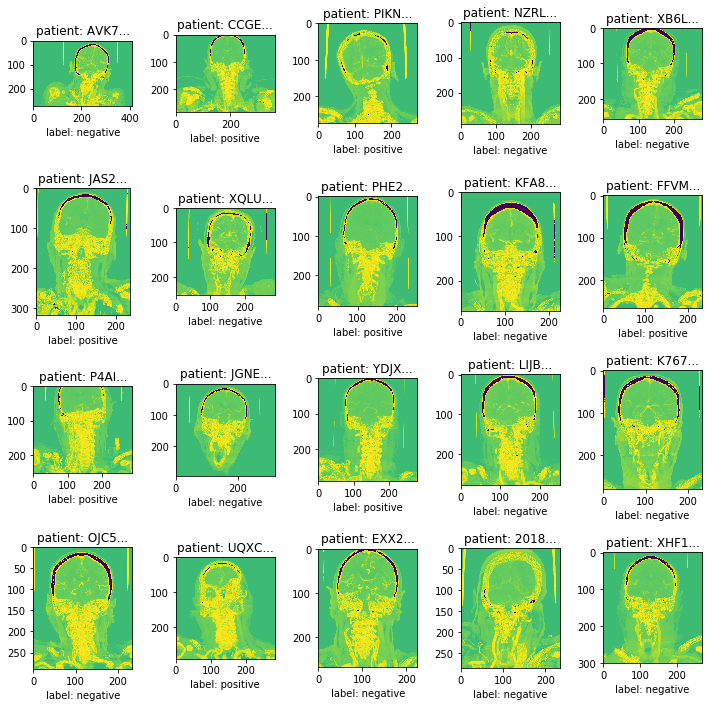

In [171]:
plot_images({k: arr[:,:,2] for k, arr in processed_dict.items()}, labels_df, 5, offset=120)

## Saving the Data

Once you've preprocessed data to your liking, you should save the data to 
disk. Load the data from disk in your model building notebook.

In [22]:
# Changed the preprocessed path
processed_dirpath = '/home/lzhu7/elvo-analysis/data/mip_three'
os.mkdir(processed_dirpath)
arr: np.ndarray
for id_, arr in processed_dict.items():
    np.save(pathlib.Path(processed_dirpath) / f'{id_}.npy', arr)

FileExistsError: [Errno 17] File exists: '/home/lzhu7/elvo-analysis/data/mip_three'

In [ ]:
processed_df.to_csv('/home/lzhu7/elvo-analysis/data/labels_mip_three.csv')

## Sharing the Data
If the data works well in models, you should share it with others.
Make sure to update the [Code and Data Doc](https://docs.google.com/document/d/1_vaNcfZ_E5KsOZH_rNf4w_wTIr7EvI8GqpZ5o3dAUV4/edit)
if you do upload to GCS.

In [ ]:
# !gsutil rsync -d -r PATH/TO/PROCESSED/DATA gs://PATH/TO/SAVE/TO

In [ ]:
 #!gsutil rsync -d PATH/TO/PROCESSED/LABELS gs://PATH/TO/SAVE/TO